Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.285 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
# 查找特定场景，比如 "scene-0103"
scene = next(scene for scene in nusc.scene if scene['name'] == 'scene-0103')

# 获取第一个样本的 token
first_sample_token = scene['first_sample_token']
first_sample_token


'3e8750f331d7499e9b5123e9eb70f2e2'

In [4]:
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility
import numpy as np
import torch
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import view_points, box_in_image
import numpy as np

# 初始化 nuScenes 对象
nusc = NuScenes(version='v1.0-mini', dataroot='../data/nuscenes', verbose=True)

X, Y, Z, W, L, H, SIN_YAW, COS_YAW, VX, VY, VZ = list(range(11))  # undecoded
CNS, YNS = 0, 1  # centerness and yawness indices in quality
YAW = 6  # decoded

classes = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker','vehicle.car','vehicle.bicycle']
pedestrians = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker'] 

def box3d_to_corners(box3d):
    if isinstance(box3d, torch.Tensor):
        box3d = box3d.detach().cpu().numpy()
    corners_norm = np.stack(np.unravel_index(np.arange(8), [2] * 3), axis=1)
    corners_norm = corners_norm[[0, 1, 3, 2, 4, 5, 7, 6]]
    # use relative origin [0.5, 0.5, 0]
    corners_norm = corners_norm - np.array([0.5, 0.5, 0.5])
    corners = box3d[:, None, [W, L, H]] * corners_norm.reshape([1, 8, 3])

    # rotate around z axis
    rot_cos = np.cos(box3d[:, YAW])
    rot_sin = np.sin(box3d[:, YAW])
    rot_mat = np.tile(np.eye(3)[None], (box3d.shape[0], 1, 1))
    rot_mat[:, 0, 0] = rot_cos
    rot_mat[:, 0, 1] = -rot_sin
    rot_mat[:, 1, 0] = rot_sin
    rot_mat[:, 1, 1] = rot_cos
    corners = (rot_mat[:, None] @ corners[..., None]).squeeze(axis=-1)
    corners += box3d[:, None, :3]
    return corners


def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image info


def threeD_2_twoD(boxsy,intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
    

    
    return min_x,max_x,min_y,max_y



def all_3d_to_2d(boxes,anns,intrinsic): #input 3d boxes, annotation key lists, intrinsic matrix (one image)
    x_min=[]
    x_max=[]
    y_min=[]
    y_max =[]
    x_min_3d = []
    x_max_3d = []
    y_min_3d = []
    y_max_3d = []
    center_3d = []
    width=[]
    height=[]
    objects_detected =[]
    orig_objects_detected =[]
    
   
    for j in range(len(boxes)): #iterate through boxes
        box=boxes[j]
        
        if box.name in classes: #if the box.name is in the classes we want to detect
        
            if box.name in pedestrians: 
                orig_objects_detected.append("pedestrian")
            elif box.name == "vehicle.car":
                orig_objects_detected.append("car")
            else:
                orig_objects_detected.append("cyclist")
            #print(box)
            
            visibility = nusc.get('sample_annotation', '%s' %anns[j])['visibility_token'] #give annotation key
            visibility = int(visibility)

            
            if visibility > 1: #more than 40% visible in the panoramic view of the the cameras

                    
                center = box.center #get boxe's center

                center = np.dot(intrinsic,center)
                center_point = center/(center[2]) #convert center point into image plane
                
                
                
                
                if center_point[0] <-100 or center_point[0] > 1700 or center_point[1] <-100 or center_point[1] >1000:
                    #if center of bounding box is outside of the image, do not annotate
                    pass
                
                else:
                    min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic) #converts box into image plane
                    w = max_x - min_x
                    h = max_y - min_y
        
        
                    x_min.append(min_x)
                    x_max.append(max_x)
                    y_min.append(min_y)
                    y_max.append(max_y)

                    x_min_3d.append(box.center[0]-box.wlh[0]/2)
                    x_max_3d.append(box.center[0]+box.wlh[0]/2)
                    y_min_3d.append(box.center[2]-box.wlh[2]/2)
                    y_max_3d.append(box.center[2]+box.wlh[2]/2)
                    center_3d.append(box.center)

                    width.append(w)
                    height.append(h)
                    if box.name in pedestrians: 
                        objects_detected.append("pedestrian")
                    elif box.name == "vehicle.car":
                        objects_detected.append("car")
                    else:
                        objects_detected.append("cyclist")
                    

            else:
                pass

    return x_min,x_max,y_min,y_max,width,height,objects_detected,orig_objects_detected, [x_min_3d, x_max_3d, y_min_3d, y_max_3d, center_3d] #for a single image

def extract_bounding_box(i,camera_name): #give a single sample number and camera name
    
    '''
    input sample number i, camera name
    outputs min x, max x, min y max y, width and height of bounding box in image coordinates
    2d bounding box
    options for camera name : CAM_FRONT, CAM_FRONT_RIGHT, CAM_FRONT_LEFT, CAM_BACK, CAM_BACK_RIGHT,CAM_BACK_LEFT
    '''
    
    nusc.sample[i] #one image
    
    camera_token = nusc.sample[i]['data']['%s' %camera_name] #one camera, get the camera token 

    path, boxes, anns, intrinsic_matrix = get_sample_data(nusc,'%s' %camera_token) #gets data for one image
    
    x_min, x_max,y_min,y_max,width,height, objects_detected,orig_objects_detected, box_3d_coord = all_3d_to_2d(boxes,anns, intrinsic_matrix)
    
    return x_min, x_max, y_min, y_max, width, height, path, boxes,intrinsic_matrix, objects_detected,orig_objects_detected, box_3d_coord
    #info for a single image
    

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.361 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [ ]:
frame = extract_bounding_box(1, 'CAM_FRONT')
frame[-1]

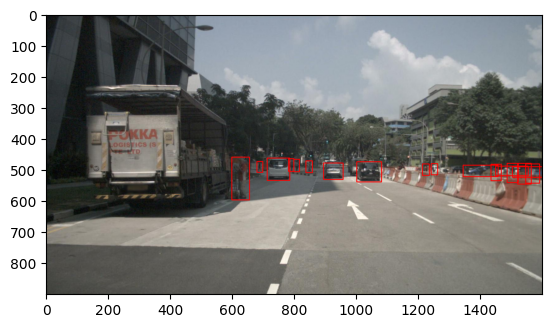

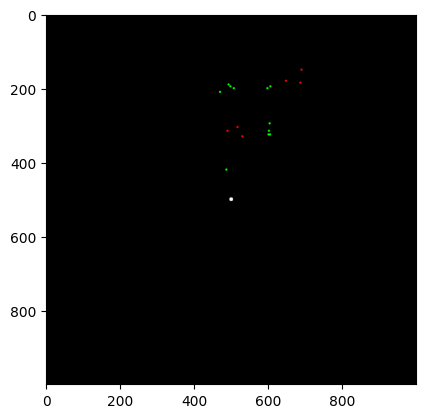

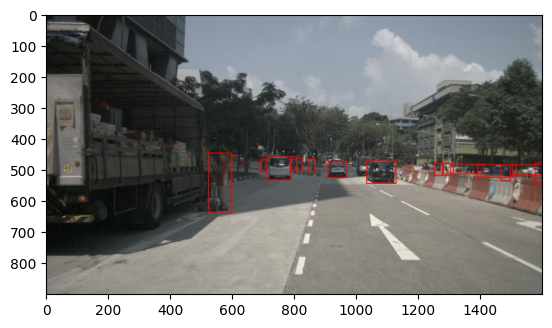

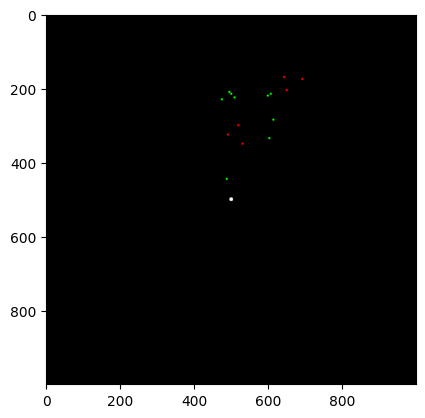

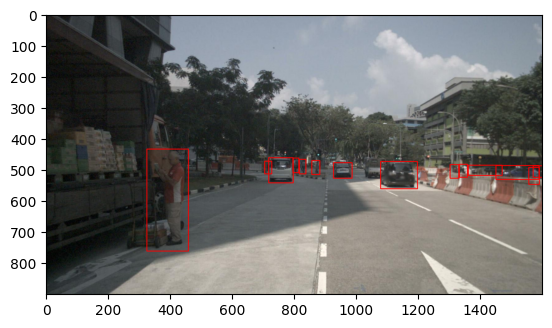

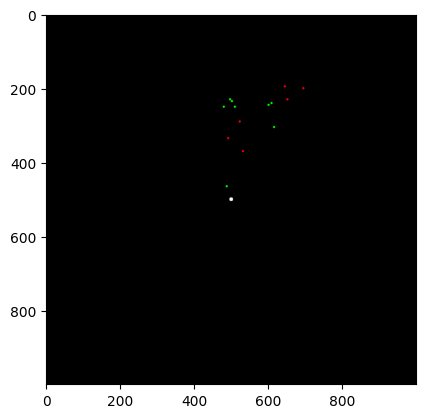

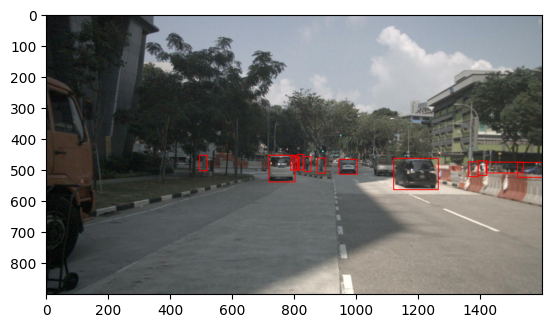

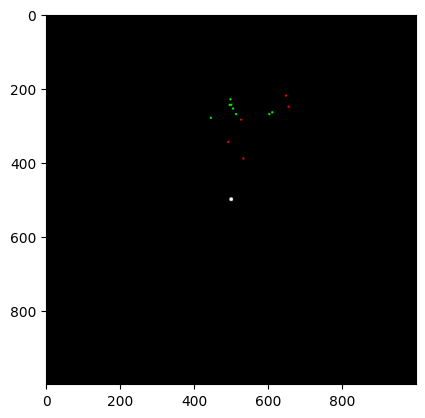

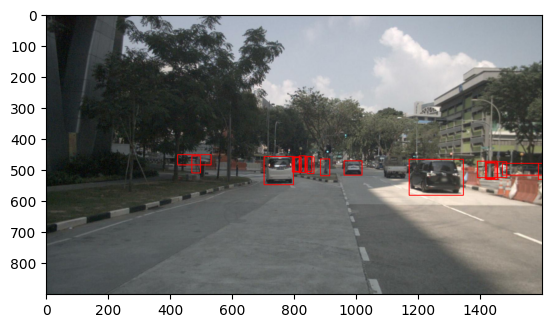

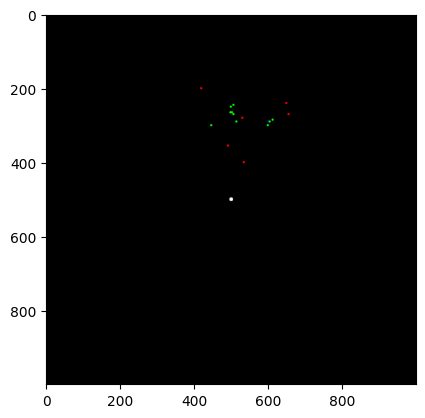

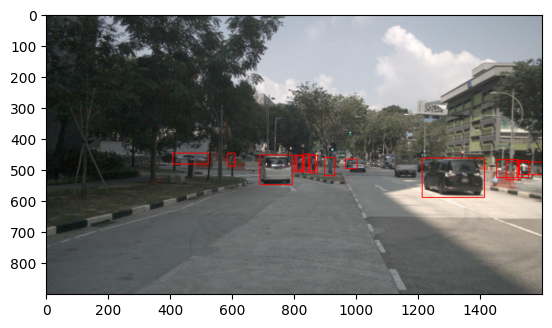

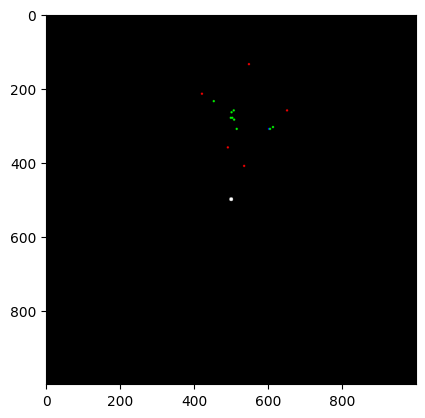

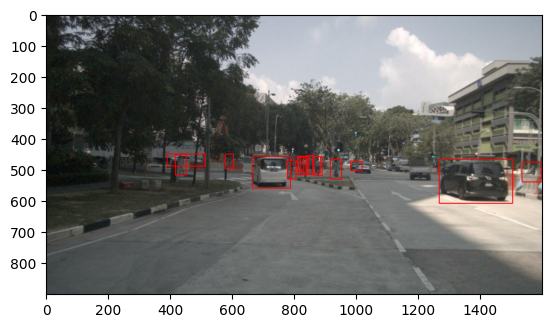

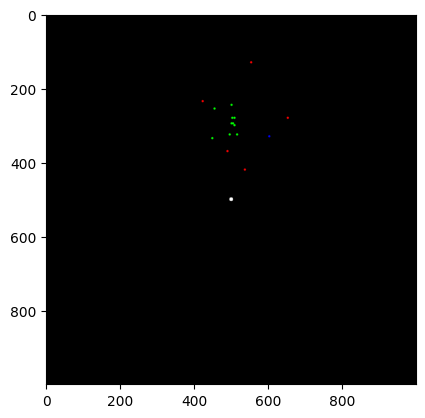

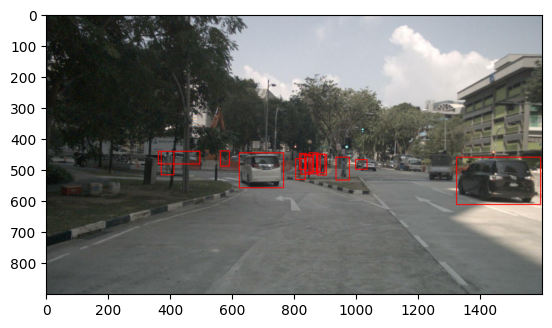

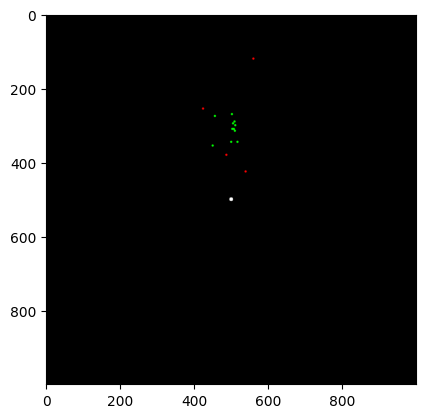

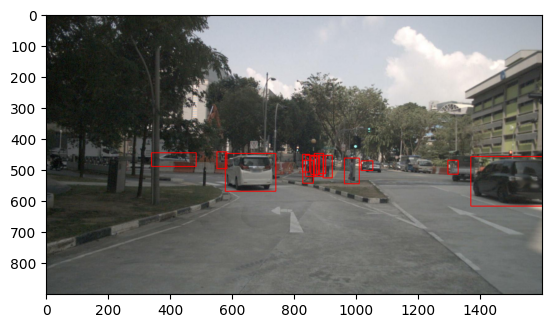

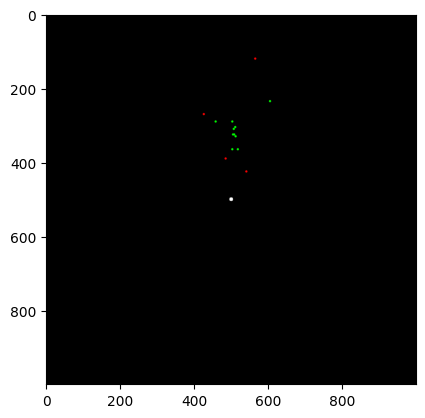

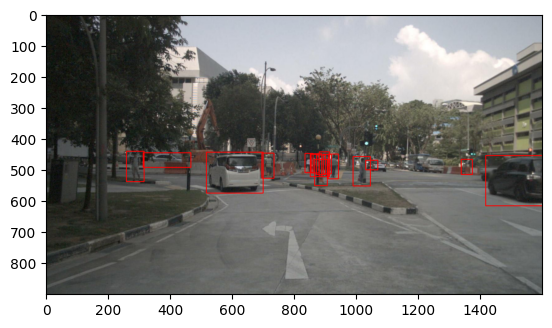

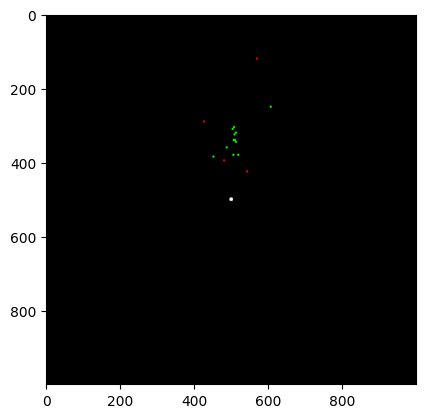

In [9]:
import cv2
import matplotlib.pyplot as plt
SCALE = 5
for i in range(10):

    frame = extract_bounding_box(i, 'CAM_FRONT')

    img = cv2.imread(frame[6])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plt.figure(figsize=(10, 10))
    for x_min, x_max, y_min, y_max in zip(frame[0], frame[1], frame[2], frame[3]):
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)

    plt.imshow(img)
    plt.show()

    img_bev = np.zeros((1000, 1000, 3), dtype=np.uint8)
    img_bev = cv2.circle(img_bev, (img_bev.shape[0] // 2, img_bev.shape[0] // 2), 5, (255, 255, 255), -1)
    
    for x_min, x_max, y_min, y_max, center_3d, obj_name in zip(frame[-1][0], frame[-1][1], frame[-1][2], frame[-1][3], frame[-1][4], frame[9]):
        x_min = int(x_min) * SCALE + img_bev.shape[0] // 2
        x_max = int(x_max) * SCALE + img_bev.shape[0] // 2
        y_min = -int(y_min) * SCALE + img_bev.shape[1] // 2
        y_max = -int(y_max) * SCALE + img_bev.shape[1] // 2
        if obj_name == 'pedestrian':
            color = (0, 255, 0)
        elif obj_name == 'car':
            color = (255, 0, 0)
        else:
            color = (0, 0, 255)
        # cv2.rectangle(img_bev, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
        cv2.circle(img_bev, (int(center_3d[0] * SCALE + img_bev.shape[0] // 2), -int(center_3d[2]) * SCALE + img_bev.shape[1] // 2), 3, color, -1)
 
    plt.imshow(img_bev)
    plt.show()